In [9]:
import os
import pickle
import re
import torch
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm 
from transformers import AutoTokenizer 

In [10]:
torch.set_default_dtype(torch.float64)

## Needed things
cdr3 length 
- based on the empirical distributions found from train data

How to choose genes
- same genes as in the test data?
- check GRU git generation system

Evaluation metrics
- GRU paper and git


## CDR3 length distributions

In [11]:
data_path = os.path.join(os.getcwd(), os.pardir, "data")
emerson_path =os.path.join(data_path, "emerson", "emerson_processed")
test_data = pd.read_csv(os.path.join(emerson_path, "whole_seqs_nn_test.tsv"), sep = '\t')

In [12]:
@numba.jit(forceobj=True)
def gene_combination_cdr3(data):
    result = {}
    for i in tqdm(range(data.shape[0]), position = 0, leave = True):
        v = f'{data[i, 3]}*{int(data[i, 4])}'
        j = f'{data[i, 6]}*{int(data[i, 7])}'
        cdr3_len = len(data[i,1])
        if (v, j) not in result.keys():
            result[(v,j)] = [cdr3_len]
        else:
            result[(v,j)].append(cdr3_len)
    return result

In [13]:
gene_cdr3 = gene_combination_cdr3(test_data.to_numpy())

100%|██████████| 26427243/26427243 [01:08<00:00, 384997.90it/s]


In [14]:
for i in tqdm(gene_cdr3.keys(), total = len(gene_cdr3), position = 0, leave = True):
    cdr3_count = {}
    total = 0
    lengths = gene_cdr3[i]
    lengths.sort()
    for j in lengths:
        key = j
        if key not in cdr3_count.keys():
            cdr3_count[key] = 1
        else:
            cdr3_count[key] += 1
        total += 1
    cdr3_count.update((x, y/total) for x, y in cdr3_count.items())
    gene_cdr3[i] = cdr3_count

100%|██████████| 359/359 [00:09<00:00, 38.13it/s] 


## Sample length 

In [15]:
def sample_length(V, J, distribution):
    genes = (V, J)
    weights = torch.tensor(list(distribution[genes].values()))
    lengths = torch.tensor(list(distribution[genes].keys()))
    return int(lengths[int(torch.multinomial(input=weights, num_samples=1,replacement=True))])

In [16]:
sample_length('TRBV7-8*1', 'TRBJ2-3*1', gene_cdr3)

16

## Fetch sequences 

In [17]:
from process_data_new import load_allele_datadict

In [18]:
allele_dict = load_allele_datadict(data_path)

In [19]:
for k, v in allele_dict.items():
    allele_dict[k] = " ".join(v[0].replace("-", "").replace(".",""))

In [37]:
@numba.jit(forceobj=True)
def fetch_sequences(data, allele_dict):
    result = []
    pattern = r'F G [A-Z] G'
    for i in tqdm(range(data.shape[0]), position = 0, leave = True):
        v = f'{data[i, 3]}*0{int(data[i, 4])}'
        seq_v = allele_dict[v]
        seq_v = seq_v[:seq_v.rfind('C')+1]
        
        
        # The last element of the cdr3 is the F in 'combining region'
        # https://www.imgt.org/IMGTrepertoire/Proteins/alleles/index.php?species=Homo%20sapiens&group=TRBJ&gene=TRBJ-overview
        
        j = f'{data[i, 6]}*0{int(data[i, 7])}'
        seq_j = allele_dict[j]
        match = re.search(pattern, seq_j)
        seq_j = seq_j[match.start()+2:] # F included in cdr3 and space is removed
        
        result.append([seq_v, seq_j])
    return result

In [38]:
data = test_data.iloc[0:2000].to_numpy()
seqs = fetch_sequences(data, allele_dict)

100%|██████████| 2000/2000 [00:00<00:00, 2378.58it/s]


In [39]:
seqs[0][1]

'G P G T R L T V T'

## Tokenize

In [2]:
tokenizer = AutoTokenizer.from_pretrained('Rostlab/prot_bert_bfd', add_special_tokens=False)

In [16]:
tokenized_seqs = []
for i in range(len(seqs)):
    V = tokenizer(seqs[i][0],  return_tensors='pt')['input_ids'][:,:-1] # remove [SEP]
    J = tokenizer(seqs[i][1],  return_tensors='pt')['input_ids'][:,1:] # remove [CLS]
    tokenized_seqs.append([V, J])
    

## Generator

https://huggingface.co/blog/how-to-generate

- The V and J genes are given to model 
- The model utilise cdr3 length distribution to sample the length of the CDR3 sequence
    - The key needs to be constructed 
- V, CDR3 and J need to be concat
    - Is there possibility to use batch --> the sequences are not generated one by one 

In [40]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [41]:
checkpoint =  torch.load("../code/model_2/030823_customprotBERT_parallel_checkpoint.pth",  map_location="cpu")
model = checkpoint["model"]
model = model.module
model.to(device)
model.eval()

CustomprotBERT(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-29): 30 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(

### 1. Greedy search

In [42]:
def greedy_search(model, Vs, Js, length):
    with torch.no_grad():
        prob = []
        cdr3_length = int(length[:,1])
        cdr3_pred =torch.full((1,cdr3_length), 0)
        for i in tqdm(range(cdr3_length), leave=True, position=0):

            src = torch.cat((Vs,cdr3_pred,Js), axis=-1)
            out = model(src=src,
                       length = length)
            cdr3_pred[:,i]= out.softmax(-1).argmax(-1)[:,i]
            prob.append(out.softmax(-1)[:,i,:])
    return cdr3_pred, prob

### 2. Temperature sampling

In [43]:
def temperature_sample(model, Vs, Js, length, temperature):
    with torch.no_grad():
        prob = []
        cdr3_length = int(length[:,1])
        cdr3_pred =torch.full((1,cdr3_length), 0)
        for i in tqdm(range(cdr3_length), leave=True, position=0):

            src = torch.cat((Vs,cdr3_pred,Js), axis=-1)
            out = model(src=src,
                       length = length)

            out = out/temperature
            probs = out.softmax(-1)
            
            next_idx = torch.multinomial(probs[:,i], num_samples=1)
            cdr3_pred[:,i]= next_idx
            prob.append(probs[:,i,:])
    return cdr3_pred, prob

### 3. Top-k

In [44]:
def top_k_sample(model, Vs, Js, length, k):
    with torch.no_grad():
        prob = []
        cdr3_length = int(length[:,1])
        cdr3_pred =torch.full((1,cdr3_length), 0)
        for i in tqdm(range(cdr3_length), leave=True, position=0):

            src = torch.cat((Vs,cdr3_pred,Js), axis=-1)
            out = model(src=src,
                       length = length)
            probs = out.softmax(-1)
            
            top_values, top_indices = torch.topk(probs[:,i], k)
            next_idx = torch.multinomial(top_values.squeeze(0), num_samples=1)
            cdr3_pred[:,i]= top_indices[:,next_idx]
            prob.append(probs[:,i,:])
    return cdr3_pred, prob

### 4. Top-p

In [45]:
def top_p_sample(model, Vs, Js, length, p):
    with torch.no_grad():
        prob = []
        cdr3_length = int(length[:,1])
        cdr3_pred =torch.full((1,cdr3_length), 0)
        for i in tqdm(range(cdr3_length), leave=True, position=0):

            src = torch.cat((Vs,cdr3_pred,Js), axis=-1)
            out = model(src=src,
                       length = length)
            probs = out.softmax(-1)
            
            sort_values, sort_indices = torch.sort(probs[:,i], descending=True, stable=True)
            cumulative_probs = torch.cumsum(sort_values, dim=-1)

            if cumulative_probs[:,0] > p:
                selected_indices = sort_indices[:,0]
                norm_probs = sort_values[:,0]/cumulative_probs[:,0][-1]
            else:
                selected_indices = sort_indices[cumulative_probs <= p]
                norm_probs = sort_values[cumulative_probs <= p]/cumulative_probs[cumulative_probs <= p][-1]
            
            next_idx = torch.multinomial(norm_probs, num_samples=1)
            cdr3_pred[:,i]= selected_indices[next_idx]
            prob.append(probs[:,i,:])
    return cdr3_pred, prob

### 5.Multinomial

In [46]:
def multinomial_sample(model, Vs, Js, CDRs, pad_mask, length):
    with torch.no_grad():
        prob = []
        cdr3_length = model.CDR3_max_length
        
        for i in tqdm(range(cdr3_length), leave=True, position=0):
            srcs = [torch.cat([v, cdr,j], axis=-1) for v, cdr, j in zip(Vs,Js,CDRs)]
            #print(srcs[0].shape)
            src = torch.stack(srcs).to(torch.int)
            #print(src)
            out = model(src=src,
                       length = length,
                       pad_mask =pad_mask)
            #print(torch.multinomial(out.softmax(-1)[:,i], num_samples=1))
            for j in range(len(CDRs)):
                if i > CDRs[j].shape[-1]-1:
                    continue
                CDRs[j][i]= torch.multinomial(out.softmax(-1)[j,i], num_samples=1)
            #prob.append(out.softmax(-1)[:,i,:])
    return CDRs

## test strategies

In [24]:
idx = 588
input_data = tokenized_seqs[idx]
V = input_data[0]
J = input_data[1]
V_code = f'{data[idx, 3]}*{int(data[idx, 4])}'
J_code = f'{data[idx, 6]}*{int(data[idx, 7])}' 
length = torch.tensor([V.shape[-1],sample_length(V_code, J_code, gene_cdr3)]).unsqueeze(0)

#cdr3_pred, prob = greedy_search(model, V, J, length)
#cdr3_pred, prob = temperature_sample(model, V, J, length, 0.01)
#cdr3_pred, prob = top_k_sample(model, V, J, length, 6)
cdr3_pred, prob = top_p_sample(model, V, J, length, 0.90)
#cdr3_pred, prob = multinomial_sample(model, V, J, length)

100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


## Dataset for generator 

In [47]:
import torch
from process_data_new import load_allele_datadict

class GeneratorDataset(torch.utils.data.Dataset):
    def __init__(self, data, cdr3_length_distribution, tokenizer, CDR3_max_length):
        
        self.cdr3_length_distribution = cdr3_length_distribution
        self.tokenizer = tokenizer
        self.CDR3_max_length = CDR3_max_length
        self.V, self.J = fetch_sequences(data)
        self.V_codes, self.J_codes = fetch_sequence_codes(data)
        
        if len(self.V) == 1:
            self.V_max_length = len(V[0].split()) + 1 #[CLS] token
            self.J_max_length = len(J[0].split()) + 2 #[SEP] token and one [PAD]
        else:
            length = 0
            V_length = 0
            J_length = 0
            for i in range(len(self.V)):
                #print(self.V[i])
                V_length = max(V_length, len(self.V[i].split()) + 1) #[CLS] token
                J_length = max(J_length, len(self.J[i].split()) + 2) #[SEP] token and one [PAD]
            
            self.V_max_length = V_length 
            self.J_max_length =  J_length 
            self.max_length = V_length + J_length + CDR3_max_length 
 
    def __len__(self):
        return len(self.V)

    def __getitem__(self, idx):
        
        cdr3_length = self.sample_length(self.V_codes[idx], self.J_codes[idx])
        CDR3 = cdr3_length * "[UNK]"
        seq = self.V[idx] + " " + CDR3 + " " + self.J[idx]
        
        tokenized = self.tokenizer(seq, padding= 'max_length', max_length= self.max_length, return_tensors='pt', return_attention_mask=True)
        
        padded_tokenized_seq = tokenized['input_ids']
        pad_mask = ~tokenized['attention_mask'].to(torch.bool)
        
        
        v_len = len(self.V[idx].split()) + 1 # Tokenizer adds [CLS] token at the beginning of the sequence
        lengths = torch.tensor([v_len, cdr3_length])
        
        V = padded_tokenized_seq[:, :v_len]
        J = padded_tokenized_seq[:, v_len+cdr3_length:]
        CDR3 = torch.zeros((cdr3_length))
        
        item = {'v': V.squeeze(0),
                'j': J.squeeze(0),
                'cdr3': CDR3,
                'length': lengths,
                'pad_mask': pad_mask.squeeze(0)}
        
        return item
    
    def sample_length(self,V, J):
        genes = (V, J)
        weights = torch.tensor(list(self.cdr3_length_distribution[genes].values()))
        lengths = torch.tensor(list(self.cdr3_length_distribution[genes].keys()))
        return int(lengths[int(torch.multinomial(input=weights, num_samples=1,replacement=True))])
    

@numba.jit(forceobj=True)
def fetch_sequences(data):
    allele_dict = load_allele_datadict(data_path) #remember to replace path
    for k, v in allele_dict.items():
        allele_dict[k] = " ".join(v[0].replace("-", "").replace(".",""))
        
    Vs, Js = [None]*data.shape[0], [None]*data.shape[0]
    for i in tqdm(range(data.shape[0]), position = 0, leave = True):
        v = f'{data[i, 3]}*0{int(data[i, 4])}'
        seq_v = allele_dict[v]
        Vs[i] = seq_v[:seq_v.rfind('C')+1]
        
        # The last element of the cdr3 is the F in 'combining region'
        # https://www.imgt.org/IMGTrepertoire/Proteins/alleles/index.php?species=Homo%20sapiens&group=TRBJ&gene=TRBJ-overview
        
        pattern = r'F G [A-Z] G'
        j = f'{data[i, 6]}*0{int(data[i, 7])}'
        seq_j = allele_dict[j]
        match = re.search(pattern, seq_j)
        Js[i] = seq_j[match.start()+1:] # F included in cdr3 
    
    return  Vs, Js

@numba.jit(forceobj=True)
def fetch_sequence_codes(data):
    V_codes, J_codes = [None]*data.shape[0], [None]*data.shape[0]
    for i in tqdm(range(data.shape[0]), position = 0, leave = True):
        V_codes[i] = f'{data[i, 3]}*{int(data[i, 4])}'
        J_codes[i] = f'{data[i, 6]}*{int(data[i, 7])}'
        
    return V_codes, J_codes

In [48]:
def collate(list_of_samples):
        result = {}
        for sample in list_of_samples:
            for k, v in sample.items():
                if k not in result.keys():
                    result[k] = [v]

                else:
                    result[k].append(v)
                    
        for k, v in result.items():
            if k == 'v' or k == 'j' or k =='cdr3':
                continue
            result[k] = torch.stack(v)
        return result

In [49]:
test_set = GeneratorDataset(test_data.iloc[:2000].to_numpy(), gene_cdr3, tokenizer, model.CDR3_max_length)
test_loader = DataLoader(test_set, shuffle=False, batch_size=8, collate_fn=collate)

100%|██████████| 2000/2000 [00:00<00:00, 4807.31it/s]


In [50]:
for batch in test_loader:
    cdr3_pred = multinomial_sample(model, batch['v'], batch['j'], batch['cdr3'], batch['pad_mask'], batch['length'])
    break

  0%|          | 0/26 [00:00<?, ?it/s]/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-03/6a700484/lib/python3.10/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
100%|██████████| 26/26 [05:13<00:00, 12.05s/it]


In [75]:
cdr3_pred[1]

tensor([10.,  6., 16.,  7., 15., 17., 24., 17., 11., 19., 22., 19., 19., 20.,
        22., 20.])

In [84]:
tokenizer.decode(cdr3_pred[7].to(torch.int))

'S I G A E L K I H M F F Y'

NameError: name 'names' is not defined

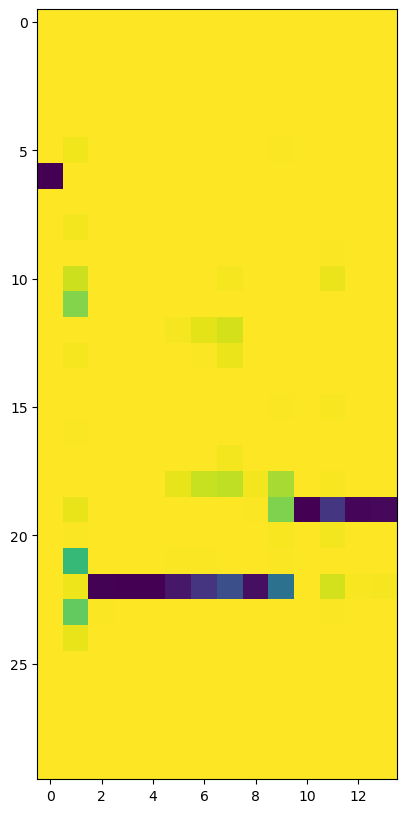

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(torch.cat(prob, dim=0).t(), cmap='viridis_r')
plt.yticks(range(0,30), names)
plt.xticks(range(0,int(length[:,1])), range(0, int(length[:,1])))
plt.colorbar()
plt.show